# TASK

HuggingFace로 MNLI 모순 분류 구현하기

Task: Multi-genre Natural Language Inference (MNLI)
문제 설명:
두 개의 문장(전제(premise)와 가설(hypothesis))이 주어졌을 때, 두 문장이 서로 논리적으로 연결되어 있는지, 모순되는지, 혹은 관련이 없는지를 판별하는 문제입니다.

- **입력**: premise에 해당하는 문장과 hypothesis에 해당하는 문장 두 개가 입력으로 들어옵니다.
- **출력:** 분류 문제로, 두 문장이 들어왔을 때 다음 세 가지를 예측하시면 됩니다.
    - **Entailment:** 두 문장에 논리적 모순이 없습니다.
    - **Neutral:** 두 문장은 논리적으로 관련이 없습니다.
    - **Contradiction:** 두 문장 사이에 논리적 모순이 존재합니다.


In [25]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer

## Dataset 준비

논리적 모순 분류 dataset을 준비하겠습니다.
Dataset은 `nyu-mll/glue`을 활용합니다.

In [26]:
glues = load_dataset("nyu-mll/glue", "mnli")
glues["train"][1]
# print(data['train']['features']['label'])
print(glues)
print(glues['train'].features['label'])

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)


어떻게 합치지

두 문장을 `premise` , `hypothesis`에 저장하고 있음
label은 names=['entailment', 'neutral', 'contradiction'] 를 저장함


# 모델 선정

테스크에 맞는 태그를 찾아서 가장 많이 사용하는 모델을 가져옴


BAAI/bge-m3 는 허깅페이스 지원안해서 안씀

http://github.com/FlagOpen/FlagEmbedding

In [27]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"


tokenizer = AutoTokenizer.from_pretrained(model_name)

# 해결 방식 설계

문장의 의미를 해석하고 관련 있음 , 관련 없음, 관련 있고 모순됨 을 구분해야한다  
토크나이저의 경우 언어 모델의 특성 상 모델에 종속적이다
그래서 AutoTokenizer.from_pretrained 로 토크나이저를 가져오는 것이라고 해석했다


https://www.sbert.net/docs/cross_encoder/training_overview.html

In [ ]:
max_length = 256

# 2. 전처리 함수 정의 (수정된 버전)
def preprocess_function(data):
    # 배치 데이터에서 직접 추출
    premises = data["premise"]
    hypotheses = data["hypothesis"]
    
    model_inputs = tokenizer(
        premises,
        hypotheses,
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
    
    model_inputs["labels"] = data["label"]
    return model_inputs

# 3. 전체 데이터셋에 전처리 적용
tokenized_dataset = glues.map(
    preprocess_function, 
    batched=True,
    remove_columns=glues["train"].column_names  # 원본 컬럼 제거
)

# 4. 필요한 데이터셋 분할
train_dataset = tokenized_dataset["train"]
val_matched_dataset = tokenized_dataset["validation_matched"]
val_mismatched_dataset = tokenized_dataset["validation_mismatched"]

test_matched_dataset = tokenized_dataset["test_matched"]
test_mismatched_dataset = tokenized_dataset["test_mismatched"]

# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')



Map: 100%|██████████| 9815/9815 [00:00<00:00, 11609.50 examples/s]


In [29]:
train_dataset[0]

{'input_ids': [101,
  17158,
  2135,
  6949,
  8301,
  25057,
  2038,
  2048,
  3937,
  9646,
  1011,
  4031,
  1998,
  10505,
  1012,
  102,
  4031,
  1998,
  10505,
  2024,
  2054,
  2191,
  6949,
  8301,
  25057,
  2147,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

기계번역과 같이 입력과 출력을 모두 tokenize하는 경우에는 출력 text를 `tokenizer`의 `text_target`인자로 넘겨주면 됩니다. 이처럼 기계 번역 dataset을 불러오는 것은 imdb dataset과 별반 다르지 않습니다.

마지막으로 `data_collator`를 다음과 같이 구현합니다.

In [30]:
# 1. 데이터셋 기본 정보 확인
print("=== 데이터셋 구조 확인 ===")
print(tokenized_dataset)
print("\n=== 학습 데이터 크기 ===")
print(f"학습 데이터 수: {len(tokenized_dataset['train'])}")

# 2. 실제 데이터 샘플 확인
print("\n=== 데이터 샘플 확인 ===")
sample_idx = 0  # 첫 번째 샘플 확인
sample = tokenized_dataset['train'][sample_idx]

# 3. 토큰화된 텍스트 복원
print("\n=== 토큰화된 텍스트 복원 ===")
decoded_premise = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
decoded_hypothesis = tokenizer.decode(sample['labels'], skip_special_tokens=True)
print(f"Premise: {decoded_premise}")
print(f"Hypothesis: {decoded_hypothesis}")

# 4. 입력 형태 확인
print("\n=== 입력 데이터 형태 확인 ===")
print(f"input_ids 길이: {len(sample['input_ids'])}")
print(f"attention_mask 길이: {len(sample['attention_mask'])}")
print(f"레이블: {sample['labels']}")

# 5. 특수 토큰 확인
print("\n=== 특수 토큰 확인 ===")
special_tokens = tokenizer.special_tokens_map
print(f"특수 토큰: {special_tokens}")

# 6. 패딩 확인
print("\n=== 패딩 확인 ===")
padding_count = sample['attention_mask'].count(0)
print(f"패딩 토큰 수: {padding_count}")
print(f"실제 토큰 수: {len(sample['input_ids']) - padding_count}")

# 7. 레이블 분포 확인
print("\n=== 레이블 분포 확인 ===")
from collections import Counter
labels = [example['labels'] for example in tokenized_dataset['train']]
label_distribution = Counter(labels)
print(f"레이블 분포: {dict(label_distribution)}")

=== 데이터셋 구조 확인 ===
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9847
    })
})

=== 학습 데이터 크기 ===
학습 데이터 수: 392702

=== 데이터 샘플 확인 ===

=== 토큰화된 텍스트 복원 ===
Premise: conceptually cream skimming has two basic dimensions - product and geography. product and geography are what make cream skimming work.
Hypothesis: [unused0]

=== 입력 데이터 형태 확인 ===
in

In [31]:
from transformers import DataCollatorForSeq2Seq
from transformers import DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


## Model 구현

이번에는 기계번역을 위한 sequence-to-sequence 모델을 구현하겠습니다.

In [32]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # MNLI는 3개 라벨


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sequence-to-sequence 모델은 위와 같이 `AutoModelForSeq2SeqLM`을 활용하면 됩니다.
Pre-trained 모델로 `google-t5/t5-small`이라는 것을 사용하고 있습니다.
이 코드 하나로 우리는 기계 번역과 같은 문제를 풀 수 있는 encoder-decoder 구조의 모델을 구현할 수 있습니다.

## 학습

마지막으로 학습 코드를 구현하겠습니다.
학습은 감정 분석과 똑같이 `training_args`를 정의하고 `Trainer`로 이전에 구현한 것들을 모두 수합하면 됩니다.

In [33]:
# 8. 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./results/minilm-mnli",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    # 간단한 설정
    save_steps=500,
    logging_steps=100,
    # load_best_model_at_end 옵션 제거
    metric_for_best_model="accuracy",
    push_to_hub=False,
    resume_from_checkpoint=False
    # resume_from_checkpoint=True
)


In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # 기본 정확도
    accuracy = accuracy_score(labels, predictions)
    
    # 클래스별 정밀도, 재현율, F1 점수
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, 
                                                            labels=[0, 1, 2])
    
    # 가중 평균 메트릭
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted')
    
    # 혼동 행렬 계산 (로깅용이 아닌 콘솔 출력용)
    conf_mat = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)
    
    # 클래스 이름
    label_names = ['entailment', 'neutral', 'contradiction']
    
    # 결과 딕셔너리 (숫자형 값만 포함)
    results = {
        'accuracy': accuracy,
        'weighted_f1': weighted_f1,
        'weighted_precision': weighted_precision, 
        'weighted_recall': weighted_recall
    }
    
    # 클래스별 메트릭 추가
    for i, label in enumerate(label_names):
        results[f'{label}_precision'] = precision[i]
        results[f'{label}_recall'] = recall[i]
        results[f'{label}_f1'] = f1[i]
    
    return results

In [35]:

# 10. Trainer 초기화 및 학습
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_matched_dataset,  # 검증 데이터셋으로 matched 사용
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/var/folders/t4/5cn643kn7ls_6vyl6y51gnnm0000gn/T/ipykernel_83833/1842638463.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


마지막으로 학습하면 다음과 같습니다.

In [36]:
# 11. 모델 학습
trainer.train()

# 12. 모델 평가 - validation_mismatched 데이터셋도 평가
mismatched_results = trainer.evaluate(val_mismatched_dataset)
print(f"Mismatched validation results: {mismatched_results}")
trainer.save_model()

KeyboardInterrupt: 

학습 결과를 보면 다음과 같습니다.

보시다시피 성능이 그렇게 좋지 않습니다. 아마 더 많은 학습 시간을 요구하는 듯 합니다.

하지만 중요한 것은 data부터 모델, 학습 코드 구현까지 매우 쉽게 했다는 것입니다.

In [40]:
%pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.



===== 종합 평가 결과 =====
데이터셋                 정확도        가중F1       가중정밀도      가중재현율     
----------------------------------------------------------------------
Confusion Matrix:
[[2809  419  251]
 [ 316 2368  439]
 [ 274  405 2534]]
Validation Matched   0.7856     0.7859     0.7863     0.7856    
Confusion Matrix:
[[2809  419  251]
 [ 316 2368  439]
 [ 274  405 2534]]
Confusion Matrix:
[[2863  386  214]
 [ 357 2351  421]
 [ 274  414 2552]]
Validation Mismatched 0.7899     0.7899     0.7899     0.7899    
Confusion Matrix:
[[2863  386  214]
 [ 357 2351  421]
 [ 274  414 2552]]
Confusion Matrix:
[[   0 3368 3209 3219]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Matched         0.0000     0.0000     0.0000     0.0000    


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0 3368 3209 3219]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
Confusion Matrix:
[[   0 3549 3083 3215]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Mismatched      0.0000     0.0000     0.0000     0.0000    


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix:
[[   0 3549 3083 3215]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]

===== 클래스별 상세 결과 =====

[entailment 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.8264     0.8074     0.8168    
Validation Mismatched 0.8194     0.8267     0.8231    
Test Matched         0.0000     0.0000     0.0000    
Test Mismatched      0.0000     0.0000     0.0000    

[neutral 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.7419     0.7582     0.7500    
Validation Mismatched 0.7461     0.7514     0.7487    
Test Matched         0.0000     0.0000     0.0000    
Test Mismatched      0.0000     0.0000     0.0000    

[contradiction 클래스 결과]
데이터셋                 Precision  Recall     F1 Score  
-------------------------------------------------------
Validation Matched   0.7860     0.7887

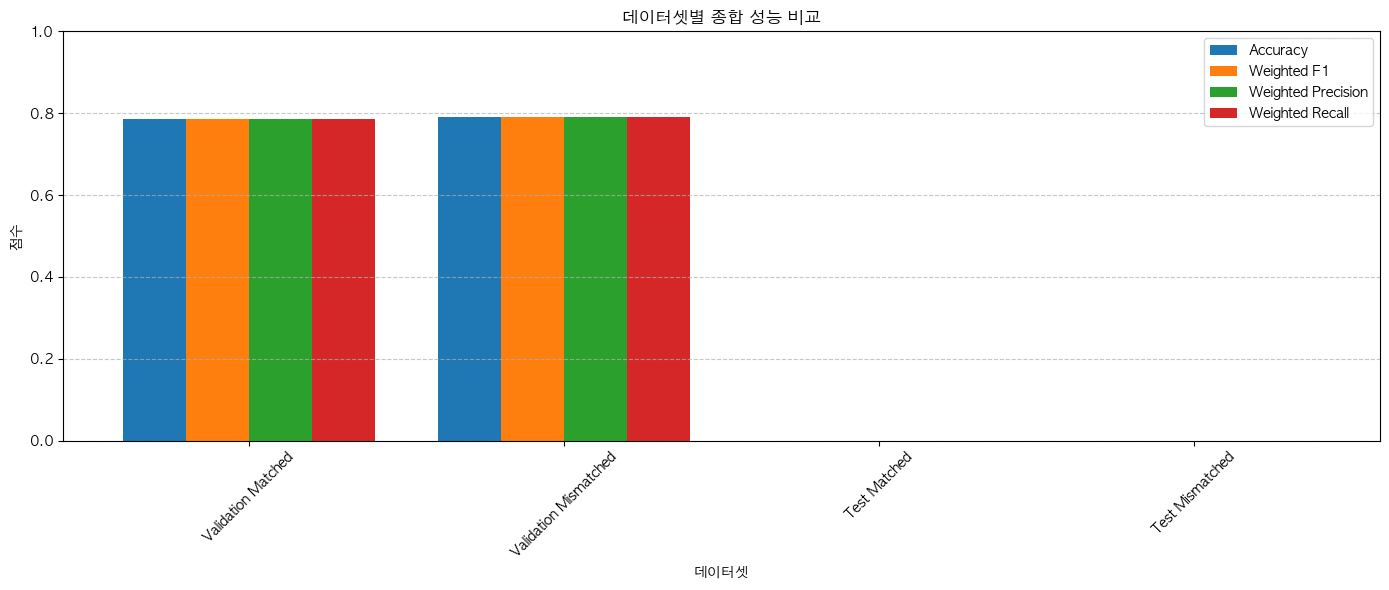

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.font_manager as fm
import platform
import os

# 저장할 상대 경로 설정
output_dir = "png/visualizations"

# 경로가 존재하지 않으면 생성
os.makedirs(output_dir, exist_ok=True)

# 운영체제별 기본 폰트 설정
if platform.system() == 'Windows':
    font_name = 'Malgun Gothic'  # 윈도우의 경우 맑은 고딕
elif platform.system() == 'Darwin':  # Mac OS
    font_name = 'AppleGothic'
else:  # Linux 등 기타 OS
    font_name = 'NanumGothic'  # 나눔고딕

# 폰트 설정
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

def plot_class_metrics(eval_results, dataset_name):
    """클래스별 성능 메트릭을 시각화하는 함수"""
    class_names = ['entailment', 'neutral', 'contradiction']
    
    # 클래스별 메트릭 추출
    f1_scores = [eval_results[f'eval_{label}_f1'] for label in class_names]
    precision_scores = [eval_results[f'eval_{label}_precision'] for label in class_names]
    recall_scores = [eval_results[f'eval_{label}_recall'] for label in class_names]
    
    # 그래프 생성
    plt.figure(figsize=(10, 6))
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.bar(x - width, precision_scores, width, label='Precision', color='#5DA5DA')
    plt.bar(x, recall_scores, width, label='Recall', color='#FAA43A')
    plt.bar(x + width, f1_scores, width, label='F1', color='#60BD68')
    
    plt.xlabel('클래스')
    plt.ylabel('점수')
    plt.title(f'클래스별 성능 메트릭 - {dataset_name}')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 각 막대 위에 값 표시
    for i, v in enumerate(precision_scores):
        plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    for i, v in enumerate(recall_scores):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    for i, v in enumerate(f1_scores):
        plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    
    plt.tight_layout()
    output_path = os.path.join(output_dir, f'class_metrics_{dataset_name.replace(" ", "_").lower()}.png')
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    return {
        'class_names': class_names,
        'precision': precision_scores,
        'recall': recall_scores,
        'f1': f1_scores
    }

def evaluate_and_visualize_all_datasets(trainer, datasets):
    """모든 데이터셋에 대한 평가 및 시각화를 수행하는 함수"""
    print("\n===== 종합 평가 결과 =====")
    print(f"{'데이터셋':<20} {'정확도':<10} {'가중F1':<10} {'가중정밀도':<10} {'가중재현율':<10}")
    print("-" * 70)
    
    all_results = {}
    class_metrics = {}
    
    # 각 데이터셋 평가
    for name, dataset in datasets.items():
        results = trainer.evaluate(eval_dataset=dataset)
        all_results[name] = results
        
        # 결과 출력
        print(f"{name:<20} {results['eval_accuracy']:<10.4f} {results['eval_weighted_f1']:<10.4f} "
              f"{results['eval_weighted_precision']:<10.4f} {results['eval_weighted_recall']:<10.4f}")
        
        # 클래스별 메트릭 시각화
        class_metrics[name] = plot_class_metrics(results, name)
        
        # 혼동 행렬 계산 및 시각화
        predictions, labels, _ = trainer.predict(dataset)
        pred_labels = np.argmax(predictions, axis=1)
        cm = confusion_matrix(labels, pred_labels)
        print(f"Confusion Matrix:")
        print(cm)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_metrics[name]['class_names'],
                    yticklabels=class_metrics[name]['class_names'])
        plt.xlabel('예측 레이블')
        plt.ylabel('실제 레이블')
        plt.title(f'혼동 행렬 - {name}')
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
        plt.savefig(output_path, dpi=300)
        plt.close()
    
    # 클래스별 F1 점수 비교 (모든 데이터셋)
    plt.figure(figsize=(15, 6))
    
    # 데이터셋별로 클래스 F1 점수 비교 그래프 생성
    dataset_names = list(datasets.keys())
    class_names = class_metrics[dataset_names[0]]['class_names']
    x = np.arange(len(class_names))
    width = 0.8 / len(dataset_names)
    
    for i, dataset_name in enumerate(dataset_names):
        offset = (i - len(dataset_names)/2 + 0.5) * width
        plt.bar(x + offset, class_metrics[dataset_name]['f1'], width, 
                label=dataset_name)
    
    plt.xlabel('클래스')
    plt.ylabel('F1 점수')
    plt.title('모든 데이터셋의 클래스별 F1 점수 비교')
    plt.xticks(x, class_names)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'all_datasets_f1_comparison.png')
    plt.savefig(output_path, dpi=300)
    plt.close()
    
    # 데이터셋별 주요 메트릭 비교
    metrics = ['eval_accuracy', 'eval_weighted_f1', 'eval_weighted_precision', 'eval_weighted_recall']
    metric_names = ['Accuracy', 'Weighted F1', 'Weighted Precision', 'Weighted Recall']
    
    plt.figure(figsize=(14, 6))
    x = np.arange(len(dataset_names))
    width = 0.8 / len(metrics)
    
    for i, metric in enumerate(metrics):
        offset = (i - len(metrics)/2 + 0.5) * width
        values = [all_results[name][metric] for name in dataset_names]
        plt.bar(x + offset, values, width, label=metric_names[i])
    
    plt.xlabel('데이터셋')
    plt.ylabel('점수')
    plt.title('데이터셋별 종합 성능 비교')
    plt.xticks(x, dataset_names, rotation=45)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'dataset_comparison.png')
    plt.savefig(output_path, dpi=300)
    
    # 각 클래스별 상세 결과표 출력
    print("\n===== 클래스별 상세 결과 =====")
    for cls in class_names:
        print(f"\n[{cls} 클래스 결과]")
        print(f"{'데이터셋':<20} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
        print("-" * 55)
        for name in dataset_names:
            idx = class_names.index(cls)
            print(f"{name:<20} {class_metrics[name]['precision'][idx]:<10.4f} "
                  f"{class_metrics[name]['recall'][idx]:<10.4f} "
                  f"{class_metrics[name]['f1'][idx]:<10.4f}")
    
    print(f"\n평가 결과 시각화 파일이 {output_dir} 디렉토리에 생성되었습니다:")
    print("1. 각 데이터셋별 클래스 메트릭 그래프 (class_metrics_*.png)")
    print("2. 각 데이터셋별 혼동 행렬 (confusion_matrix_*.png)")
    print("3. 모든 데이터셋의 클래스별 F1 점수 비교 (all_datasets_f1_comparison.png)")
    print("4. 데이터셋별 종합 성능 비교 (dataset_comparison.png)")
    
    return all_results, class_metrics

# 사용 예시
datasets = {
    "Validation Matched": val_matched_dataset, 
    "Validation Mismatched": val_mismatched_dataset,
    "Test Matched": test_matched_dataset,
    "Test Mismatched": test_mismatched_dataset
}

# 모든 데이터셋 평가 및 시각화
results, class_metrics = evaluate_and_visualize_all_datasets(trainer, datasets)

In [38]:
# 종합 결과 표 출력
print("\n===== 종합 평가 결과 =====")
print(f"{'데이터셋':<20} {'정확도':<10} {'가중F1':<10} {'가중정밀도':<10} {'가중재현율':<10}")
print("-" * 70)

datasets = {
    "Validation Matched": val_matched_dataset, 
    "Validation Mismatched": val_mismatched_dataset,
    "Test Matched": tokenized_dataset["test_matched"],
    "Test Mismatched": tokenized_dataset["test_mismatched"]
}

for name, dataset in datasets.items():
    results = trainer.evaluate(eval_dataset=dataset)
    print(f"{name:<20} {results['eval_accuracy']:<10.4f} {results['eval_weighted_f1']:<10.4f} "
          f"{results['eval_weighted_precision']:<10.4f} {results['eval_weighted_recall']:<10.4f}")


===== 종합 평가 결과 =====
데이터셋                 정확도        가중F1       가중정밀도      가중재현율     
----------------------------------------------------------------------
Confusion Matrix:
[[2809  419  251]
 [ 316 2368  439]
 [ 274  405 2534]]
Validation Matched   0.7856     0.7859     0.7863     0.7856    
Confusion Matrix:
[[2863  386  214]
 [ 357 2351  421]
 [ 274  414 2552]]
Validation Mismatched 0.7899     0.7899     0.7899     0.7899    
Confusion Matrix:
[[   0 3368 3209 3219]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Matched         0.0000     0.0000     0.0000     0.0000    
Confusion Matrix:
[[   0 3549 3083 3215]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/hugging/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Mismatched      0.0000     0.0000     0.0000     0.0000    
